# Generate poisson probability graph

2020-02-20 00:01:12
2020-02-20 00:01:12
2020-02-20 00:01:22
2020-02-20 00:01:22
2020-02-20 00:01:32
2020-02-20 00:01:32
2020-02-20 00:01:42
2020-02-20 00:01:42
2020-02-20 00:01:53
2020-02-20 00:01:53
2020-02-20 00:02:03
2020-02-20 00:02:03
2020-02-20 00:02:13
2020-02-20 00:02:13
2020-02-20 00:02:23
2020-02-20 00:02:23
2020-02-20 00:02:33
2020-02-20 00:02:33
2020-02-20 00:02:43
2020-02-20 00:02:43
2020-02-20 00:02:53
2020-02-20 00:02:53
2020-02-20 00:03:04
2020-02-20 00:03:04
2020-02-20 00:03:14
2020-02-20 00:03:14
2020-02-20 00:03:24
2020-02-20 00:03:24
2020-02-20 00:03:34
2020-02-20 00:03:34
2020-02-20 00:03:44
2020-02-20 00:03:44
2020-02-20 00:03:54
2020-02-20 00:03:54
2020-02-20 00:04:04
2020-02-20 00:04:04
2020-02-20 00:04:15
2020-02-20 00:04:15
2020-02-20 00:04:25
2020-02-20 00:04:25
2020-02-20 00:04:35
2020-02-20 00:04:35
2020-02-20 00:04:45
2020-02-20 00:04:45
2020-02-20 00:04:55
2020-02-20 00:04:55
2020-02-20 00:05:05
2020-02-20 00:05:05
2020-02-20 00:05:15
2020-02-20 00:05:15


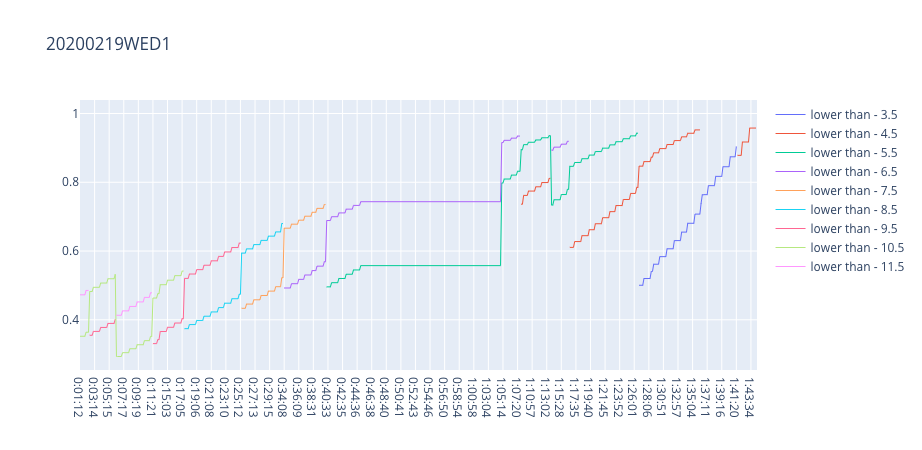

In [36]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, time, date
import plotly.graph_objects as go
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/')
# one example

event_id = '20200219WED11'

def poisson(lambda_t):
    return [math.exp(-1 * lambda_t) * (lambda_t ** k) / math.factorial(k) for k in range(21)]

# truncating half time times to time 45
# assuming 20 minutes of half time ie. time 45-65
def minute_adjust(x, adjust=timedelta(0,20,0)): 
    # read in HH:MM:SS string, output HH:MM:SS string
    x = datetime.strptime(x, '%H:%M:%S').time()
    if x <= time(0,45,0):
        x = datetime.combine(date.today(), x)
    elif time(0,45,0) < x <= time(1,5,0):
        x = datetime.combine(date.today(), time(0,45,0))
    elif x > time(1,5,0):
        x = datetime.combine(date.today(), x) - adjust
    # print(x)
    return datetime.strftime(x, '%H:%M:%S')


def poisson_pipeline(event_id):
    df = pd.read_csv('data_collection/data/'+event_id+'.csv')
    
    # remvoe NaN and ---
    df = df[(~df.total_corner.isna()) & (df.total_corner!="---") & (df.total_corner!=" ---")]
    df = df[(~df.chl_line.isna()) & (df.chl_line!="---")]
    df = df[(~df.chl_hi.isna()) & (df.chl_hi!="---")]
    df = df[(~df.chl_low.isna()) & (df.chl_low!="---")]

    df['total_corner'] = df['total_corner'].apply(pd.to_numeric)
    df['chl_line'] = df['chl_line'].apply(pd.to_numeric)
    df['chl_hi'] = df['chl_hi'].apply(pd.to_numeric)
    df['chl_low'] = df['chl_low'].apply(pd.to_numeric)

    df = df.reset_index(drop = True)
    df['hour'] = df.minutes.apply(lambda x: int(minute_adjust(x).split(':')[0]))
    df['minute'] = df.minutes.apply(lambda x: int(minute_adjust(x).split(':')[1]))
    df['time'] = df.minute+60*df.hour

    param_df = df[['minutes', 'chl_line']].groupby('minutes').mean()
    param_df = param_df.rename(columns={'chl_line':'lambda'})

    df = df.merge(param_df, how='outer', on='minutes')
    df['lambda_t'] = df['lambda'] * (1 - df['time'] / max(max(df.time),90))
    df['lambda_t_probs'] = df.lambda_t.apply(poisson)
    df['target_corner'] = (df.chl_line - df.total_corner).apply(math.floor)
    df['lower_prob'] = df.apply(lambda row: sum(row.lambda_t_probs[0:row.target_corner]), axis=1)
    df['higher_prob'] = 1-df.lower_prob

    return df[['minutes', 'chl_line', 'lower_prob', 'higher_prob']]


def prob_graph(probs, event_id):
    lines = list(set(probs.chl_line))
    data_dict = {}
    time_list = sorted(list(set(probs.minutes)))

    for line in lines:
        filtered_data = probs[probs.chl_line==line].sort_values(by=['minutes'])
        data_dict[line] = pd.DataFrame({'minutes': time_list})
        data_dict[line] = data_dict[line].merge(filtered_data, how='outer', on='minutes')

    fig = go.Figure()
    for line in lines:
        fig.add_trace(go.Scatter(x=data_dict[line]['minutes'], 
                                 y=data_dict[line]['lower_prob'], 
                                 mode='lines',
                                 name='lower than - {}'.format(line), 
                                 line=dict(width=1)))
    fig.update_layout(title=event_id)
    fig.show()

    
if __name__ == "__main__":
    for event_id in [file[:-4] for file in os.listdir('data_collection/data/') if '2020' in file]:
    #for event_id in ['20200219WED1']:
        probs = poisson_pipeline(event_id)
        prob_graph(probs, event_id)

### Mathmatical problem with the calculation

- Possion probability should not change during half time
- Current data collection does not crawl data about half time time location
- This script only use approximate half time by assuming half time at minute = 45 to 60